In [1]:
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
from tensorflow.keras.layers import Conv2D,PReLU,BatchNormalization,Flatten,UpSampling2D,LeakyReLU,Dense,Input,add

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
train_images=glob.glob("/kaggle/input/div2k-dataset/DIV2K_train_HR/DIV2K_train_HR/*")
valid_images=glob.glob("/kaggle/input/div2k-dataset/DIV2K_valid_HR/DIV2K_valid_HR/*")

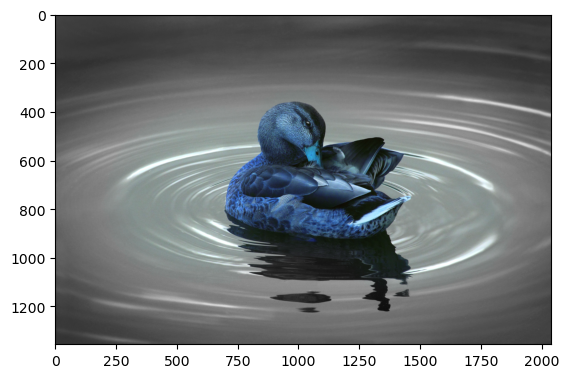

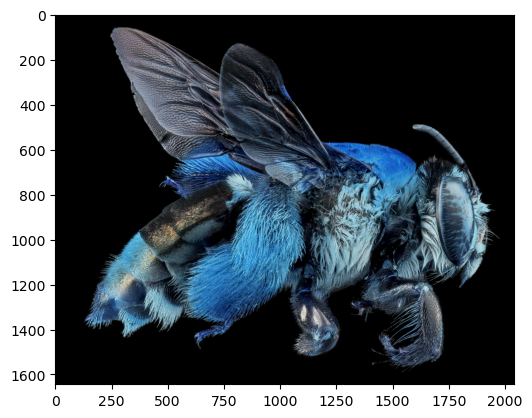

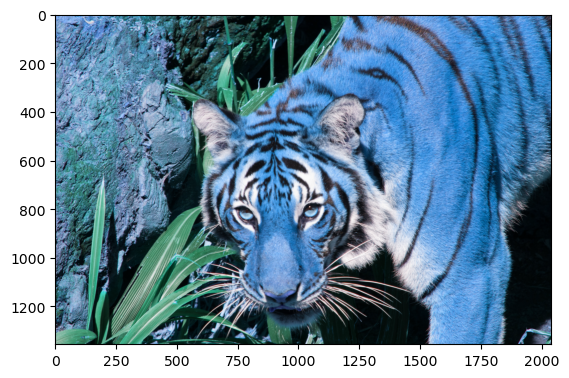

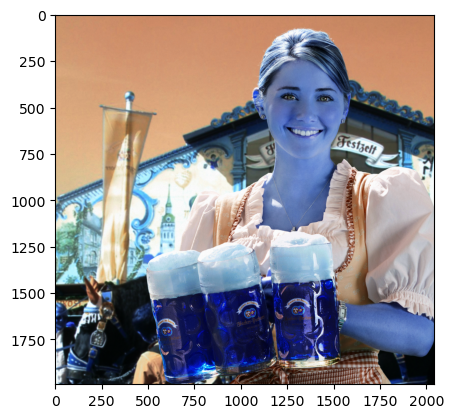

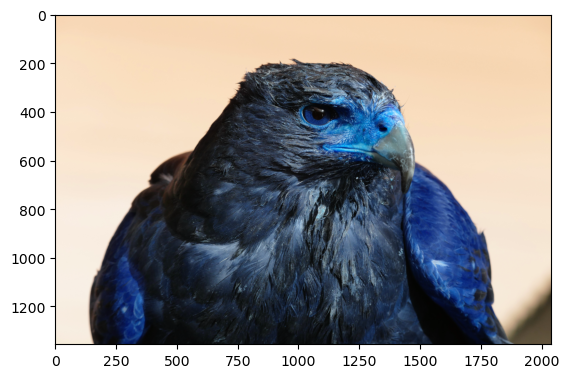

In [3]:
np.random.seed(41)
rand_ix=np.random.randint(0,799,size=5,dtype=int)
for ix in rand_ix:
    img=cv2.imread(train_images[ix])
    plt.imshow(img)
    plt.show()

One thing that can be concluded from here is that not all images have the same aspect ratio. Now, we can crop the images and bring them down to one particular aspect ratio that will lead to loss of information in some images. Instead, we will build a model capable of taking inputs of varying aspect ratios.

In [4]:
for dir_name in ["train_jpeg","val_jpeg"]:
    os.makedirs("/kaggle/working/"+dir_name+"/")

In [5]:
# downsample_train_images="/kaggle/working/8x_downsample_train_images_bicubic/"
# downsample_valid_images="/kaggle/working/8x_downsample_valid_images_bicubic/"

In [6]:
# for org_dir,dest_dir in zip([train_images,valid_images],
#                                [downsample_train_images,downsample_valid_images]):
#     for filename in tqdm(org_dir):
#         image=cv2.imread(filename)
#         image_1=tf.image.resize(image/255,size=tf.cast((tf.shape(image)/4)[:2],dtype='int32'),
#                                 preserve_aspect_ratio=True,antialias=True)
#         image_1=tf.image.resize(image_1,size=tf.shape(image)[:2],method=tf.image.ResizeMethod.BICUBIC,
#                                 preserve_aspect_ratio=True,antialias=True)
#         image=image_1*255
#         image_number=os.path.basename(filename).split('.')[0]
#         dest_filepath=os.path.join(dest_dir+image_number+'.png')
#         tf.io.write_file(dest_filepath,tf.image.encode_png(image))

In [7]:
train_dir="/kaggle/working/train_jpeg/"
val_dir="/kaggle/working/val_jpeg/"
for png_dir,jpeg_dir in zip([train_images,valid_images],[train_dir,val_dir]):
    for image in tqdm(png_dir):
        img_array=cv2.imread(image)
        cv2.imwrite(jpeg_dir+os.path.basename(image).split(".")[0]+".jpeg",img_array)

100%|██████████| 100/100 [00:18<00:00,  5.28it/s]


In [8]:
class Generator(keras.utils.Sequence):
    def __init__(self,x:list,y:list):
        self.x=x
        self.y=y
    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self,index):
        x=self.x[index]
        y=self.y[index]
        return x,y
    def __call__(self):
        for i in range(self.__len__()):
            yield self.__getitem__(i)
            if i==self.__len__()-1:
                self.on_epoch_end()

In [9]:
def preprocessing(path,ratio=4,resize_height=256,resize_width=256):
    hr=tf.keras.utils.load_img(path)
    hr=tf.keras.utils.img_to_array(hr)
    hr=tf.image.resize(hr,size=[resize_height,resize_width],method='bicubic',antialias=True)
#     height,width,channels=hr.shape
    lr=tf.image.resize(hr,size=[hr.shape[0]//ratio,hr.shape[1]//ratio],method='bicubic',antialias=True)
    lr=lr/255.0
    lr=lr/255.0
    return lr,hr

In [10]:
train_paths=glob.glob("/kaggle/working/train_jpeg/*")
val_paths=glob.glob("/kaggle/working/val_jpeg/*")

In [11]:
test_ix=np.random.randint(0,99,size=5,dtype=int)
test_paths=[]
for ix in test_ix:
    test_paths+=[val_paths[ix]]
    del val_paths[ix]

In [12]:
def lr_and_hr(img_paths,lr_tensor_path='./lr_tensor.npy',hr_tensor_path='./hr_tensor.npy'):
    if not(os.path.exists(lr_tensor_path)) or not(os.path.exists(hr_tensor_path)):
        img_lr = []
        img_hr = []
        for i in tqdm(range(len(img_paths))):
            lr,hr=preprocessing(img_paths[i])
            img_lr.append(lr)
            img_hr.append(hr)
        lr_tensor=tf.convert_to_tensor(img_lr).numpy()
        hr_tensor=tf.convert_to_tensor(img_hr).numpy()
        np.save('./lr_tensor.npy',lr_tensor)
        np.save('./hr_tensor.npy',hr_tensor)
        img_lr=lr_tensor
        img_hr=hr_tensor
    else:
        img_lr=np.load(lr_tensor_path)
        img_hr=np.load(hr_tensor_path)
    return img_lr,img_hr

In [13]:
generators=[]
paths=[train_paths,val_paths,test_paths]
tensor_paths=[['./lr_tensor.npy','./hr_tensor.npy'],['./lr_tensor_val.npy','./hr_tensor_val.npy'],
              ['./lr_tensor_test.npy','./hr_tensor_test.npy']]
i=0
for path_list in paths:
    x,y=lr_and_hr(path_list,lr_tensor_path=tensor_paths[i][0],hr_tensor_path=tensor_paths[i][1]) #Bug over here about tensor paths
    generators+=[Generator(x,y)]
    i+=1
train_generator=generators[0]
val_generator=generators[1]
test_generator=generators[2]

100%|██████████| 5/5 [00:00<00:00, 11.83it/s]


Text(0.5, 1.0, 'Downsampled image(Left) and High-res image(Right)')

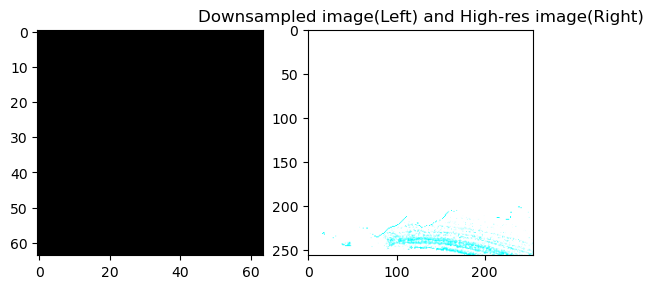

In [14]:
x,y=train_generator[0]
plt.subplot(121)
plt.imshow(x)
plt.subplot(122)
plt.imshow(y)
plt.title("Downsampled image(Left) and High-res image(Right)")

In [15]:
def dataset_preparation(generator,output_shapes=([None, None, 3],[None, None, 3]),
                        output_types=(x.dtype,y.dtype),shuffle=False,batch_size=16,prefetch_size=10):
    dataset=tf.data.Dataset.from_generator(generator,output_shapes=output_shapes,output_types=output_types).batch(batch_size)
    dataset=dataset.prefetch(prefetch_size)
    dataset=dataset.cache()
    if(shuffle==True):
        dataset=dataset.shuffle(len(generator)+1,reshuffle_each_iteration=True)
    return dataset

In [16]:
train_ds=dataset_preparation(train_generator,shuffle=True)
val_ds=dataset_preparation(val_generator)
test_ds=dataset_preparation(test_generator)

In [17]:
strategy=tf.distribute.MirroredStrategy()

In [18]:
# with strategy.scope():
#     def res_block(x):
#         res_model=Conv2D(64,(3,3),padding="same")(x)
#         res_model=BatchNormalization(momentum=0.5)(res_model)
#         res_model=PReLU(shared_axes=[1,2])(res_model)
#         res_model=Conv2D(64,(3,3),padding="same")(res_model)
#         res_model=BatchNormalization(momentum=0.5)(res_model)
#         return add([x,res_model])
    
#     def upscale_block(x):
#         up_model=Conv2D(256,(3,3),padding="same")(x)
#         up_model=UpSampling2D(size=2)(up_model)
#         up_model=PReLU(shared_axes=[1,2])(up_model)
#         return up_model
    
#     num_res_block = 16
    
#     def gen_component(x):
#         layers=Conv2D(64,(9,9),padding="same")(x)
#         layers=PReLU(shared_axes=[1,2])(layers)
#         temp=layers
#         for i in range(num_res_block):
#             layers=res_block(layers)
#         layers=Conv2D(64, (3,3), padding="same")(layers)
#         layers=BatchNormalization(momentum=0.5)(layers)
#         layers=add([layers,temp])
#         layers=upscale_block(layers)
#         layers=upscale_block(layers)
#         y=Conv2D(3,(9,9),padding="same")(layers)
#         return tf.keras.Model(inputs=x,outputs=y)
    
#     def discriminator_block(x,filters,strides=1,bn=True):
#         disc_model=Conv2D(filters,(3,3),strides,padding="same")(x)
#         disc_model=LeakyReLU(alpha=0.2)(disc_model)
#         if bn:
#             disc_model=BatchNormalization(momentum=0.8)(disc_model)
#         return disc_model
    
#     def disc_component(x):
#         df=64
#         d1=discriminator_block(x,df,bn=False)
#         d2=discriminator_block(d1,df,strides=2)
#         d3=discriminator_block(d2,df*2)
#         d4=discriminator_block(d3,df*2,strides=2)
#         d5=discriminator_block(d4,df*4)
#         d6=discriminator_block(d5,df*4,strides=2)
#         d7=discriminator_block(d6,df*8)
#         d8+discriminator_block(d7,df*8,strides=2)
#         d8_5=Flatten()(d8)
#         d9=Dense(df*16)(d8_5)
#         d10=LeakyReLU(alpha=0.2)(d9)
#         validity=Dense(1,activation='sigmoid')(d10)
#         return Model(x,validity)

#     from keras.applications import VGG19
#     # Building the VGG19 model upto 10th layer Used to extract the features of high res imgaes
#     def build_vgg():
#         vgg=VGG19(weights="imagenet")
#         vgg.outputs=[vgg.layers[9].output]
#         img=Input(shape=hr_shape)
#         img_features=vgg(img)
#         return Model(img,img_features)
#     def create_comb(gen_model,disc_model,vgg,lr,hr):
#         gen_img=gen_model(lr)
#         gen_features=vgg(gen_img)
#         disc_model.trainable=False
#         validity=disc_model(gen_img)
#         return Model([lr,hr],[validity,gen_features])
    

In [19]:
with strategy.scope():
    def FCN_model(upscale_factor=4):
        inputs=Input(shape=(None,None,3))
        x=Conv2D(64,5,activation="relu",padding="same")(inputs)
        x=Conv2D(64,3,activation="relu",padding="same")(x)
        x=Conv2D(32,3,activation="relu",padding="same")(x)
        x=Conv2D(3*(upscale_factor**2),3,activation="relu",padding="same")(x)
        outputs=tf.nn.depth_to_space(x,upscale_factor)
        return tf.keras.Model(inputs,outputs)

In [20]:
with strategy.scope():
    model=FCN_model()
    model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 64)    4864      
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    36928     
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 32)    18464     
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 48)    13872     
                                                                 
 tf.nn.depth_to_space (TFOpL  (None, None, None, 3)    0         
 ambda)                                                          
                                                             

In [21]:
with strategy.scope():
    @tf.function
    def MeanGradientError(targets,outputs):
        filter_x=tf.tile(tf.expand_dims(tf.constant([[-1,-2,-2],[0,0,0],[1,2,1]],
                                                      dtype=outputs.dtype),axis=-1),[1,1,outputs.shape[-1]])
        filter_x=tf.tile(tf.expand_dims(filter_x,axis=-1),[1,1,1,outputs.shape[-1]])
        filter_y=tf.tile(tf.expand_dims(tf.constant([[-1,0,1],[-2,0,2],[-1,0,1]],dtype=outputs.dtype),axis=-1),
                         [1, 1,targets.shape[-1]])
        filter_y=tf.tile(tf.expand_dims(filter_y,axis=-1),[1,1,1,targets.shape[-1]])
        output_gradient_x=tf.math.square(tf.nn.conv2d(outputs,filter_x,strides=1,padding='SAME'))
        output_gradient_y=tf.math.square(tf.nn.conv2d(outputs,filter_y,strides=1,padding='SAME'))
        target_gradient_x=tf.math.square(tf.nn.conv2d(targets,filter_x,strides=1,padding='SAME'))
        target_gradient_y=tf.math.square(tf.nn.conv2d(targets,filter_y,strides=1,padding='SAME'))
        output_gradients=tf.math.add(output_gradient_x,output_gradient_y)
        target_gradients=tf.math.add(target_gradient_x,target_gradient_y)
        mge=tf.keras.metrics.mean_absolute_error(output_gradients,target_gradients)
        return mge
    
    @tf.function
    def loss_sum(y_true, y_pred):
        mae=tf.keras.metrics.mean_absolute_error(y_true,y_pred)
        mge=MeanGradientError(y_true,y_pred)
        return mae+0.1*mge
    
    model.compile(optimizer="Adam",loss=loss_sum,metrics=['mae',MeanGradientError])

In [22]:
with strategy.scope():
    early_stopping=tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=15,min_delta=0.01,mode='min',
                                                    restore_best_weights=True)
    checkpoint=tf.keras.callbacks.ModelCheckpoint("/kaggle/working/model.h5",monitor="val_loss",save_best_only=True,
                                                  save_freq='epoch',mode='min')

In [23]:
with strategy.scope():
    history = model.fit(train_ds,epochs=300,verbose=True,validation_data=val_ds,callbacks=[early_stopping,checkpoint])

Epoch 1/300
50/50 [==============================] - 18s 65ms/step - loss: 38451.3555 - mae: 102.9412 - MeanGradientError: 383484.0938 - val_loss: 34955.3516 - val_mae: 92.4060 - val_MeanGradientError: 348629.4375
Epoch 2/300
50/50 [==============================] - 2s 31ms/step - loss: 32469.8398 - mae: 92.8791 - MeanGradientError: 323769.5312 - val_loss: 32578.4570 - val_mae: 89.6017 - val_MeanGradientError: 324888.5625
Epoch 3/300
50/50 [==============================] - 1s 30ms/step - loss: 30477.0781 - mae: 92.3030 - MeanGradientError: 303847.7812 - val_loss: 31386.0469 - val_mae: 92.3007 - val_MeanGradientError: 312937.4375
Epoch 4/300
50/50 [==============================] - 1s 28ms/step - loss: 30037.9648 - mae: 93.5193 - MeanGradientError: 299444.4688 - val_loss: 31206.1836 - val_mae: 92.2513 - val_MeanGradientError: 311139.3125
Epoch 5/300
50/50 [==============================] - 1s 28ms/step - loss: 29958.4395 - mae: 93.9315 - MeanGradientError: 298645.1250 - val_loss: 31176